# Medical Cost Prediction

Las aseguradoras de salud desempeñan un papel fundamental a nivel mundial, proporcionando una red de seguridad financiera esencial para los individuos ante enfermedades y emergencias médicas. Estas compañías operan bajo un modelo de negocio intrínsecamente ligado al riesgo, pues el momento y la severidad de las enfermedades de sus asegurados son inherentemente impredecibles. Para mantener su viabilidad y ofrecer un servicio de calidad, las aseguradoras deben no solo cubrir sus costos sino también generar ganancias.

A pesar de la incertidumbre que rodea la frecuencia y el tipo de reclamaciones, ciertas condiciones de salud, hábitos de vida y características demográficas ofrecen indicativos valiosos que pueden ayudar a prever si un individuo podría representar un gasto mayor. En este contexto, los modelos predictivos emergen como herramientas cruciales, permitiendo a las aseguradoras estimar de manera aproximada los costos futuros asociados a cada asegurado. Estos modelos utilizan datos históricos y tendencias para predecir gastos, facilitando así una gestión más eficiente del riesgo.

El objetivo de este proyecto es proporcionar a la compañía de seguros un sistema que oriente a sus asesores, permitiéndoles tomar decisiones informadas basadas en las recomendaciones sobre los costos previstos por un modelo previamente entrenado. Para ello, se construirá un modelo de regresión utilizando un dataset de 4,000 registros de pacientes. Cada registro incluye diversos datos sobre condiciones de salud y hábitos de vida, los cuales ya están siendo utilizados para calcular las tarifas mensuales de los servicios. Este modelo no solo busca mejorar la precisión en la predicción de los costos, sino también optimizar las estrategias de precios y políticas de cobertura para mejorar la rentabilidad y eficacia del servicio ofrecido.

<img src="medical_cost_illustration.gif" width="400px">


### Loading data
En primer lugar importamos las librerias que utilizaremos para el tratamiento de los datos, y los datos como tal.

Además se configura la manera en que se mostrarán los datos en el notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
%matplotlib inline

sns.set(style = "whitegrid", context = "notebook")
sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
plt.rcParams["figure.figsize"] = (15, 10)

import warnings
warnings.filterwarnings("ignore")


In [3]:
original_df = pd.read_csv('../data/insurance.csv')
df_raw = original_df.copy(deep=True)

In [4]:
df_raw

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Entendiendo los datos (EDA)
Para no dejar nada en el camino es fundamental comprender nuestros datos, a continuación llevaremos a cabo un **Análisis Exploratorio de datos**, comprendiendo cómo se comportan las observaciones y qué información nos pueden entregar.

### Tamaño y dimensionalidad

In [5]:
df_eda = df_raw.copy(deep=True)

print(f"El dataset original tiene {df_eda.shape[0]} observaciones y {df_eda.shape[1]} variables.")

El dataset original tiene 1338 observaciones y 7 variables.


### Categorización de las variables
La fuente de los datos nos brinda la siguiente información : 
| Campo    | Descripción                                                                                                         |
|----------|---------------------------------------------------------------------------------------------------------------------|
| age      | Edad del beneficiario principal                                                                               |
| sex      | Género del contratante del seguro                                                |
| bmi      | Índice de masa corporal                                                                                             |
| children | Número de hijos cubiertos por el seguro de salud / Número de dependientes                                             |
| smoker   | Fumador                                                                                           |
| region   | Área residencial del beneficiario en los EE. UU.  |
| charges  | Costos médicos individuales facturados por el seguro de salud                                                       |




A continuación realizaremos la validación de que los datos informados por la fuente está correcta, y verificamos los tipos de datos, y el comportamiento, de cada variable.

In [6]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
df_eda.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [8]:
df_eda.select_dtypes(include = ["object"]).describe()

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


Notemos que:
* Las variables numéricas continua son :   _age_, _bmi_, y _charges_.
* Las variables numéricas discretas son :   _children_.
* Las variables categóricas nominales son :   _sex_, _smoker_ y _region_.
* Tanto las variables categóricas como las numéricas no parecen presentar valores faltantes de manera implícita. ya que sus
    datos parecen, tanto en mínimos como en los máximos, estar dentro de los rangos esperados. por lo que podemos concluir que no hay datos faltantes en el dataset.
* La variable _charges_ es la variable objetivo.

### Análisis de variables numéricas

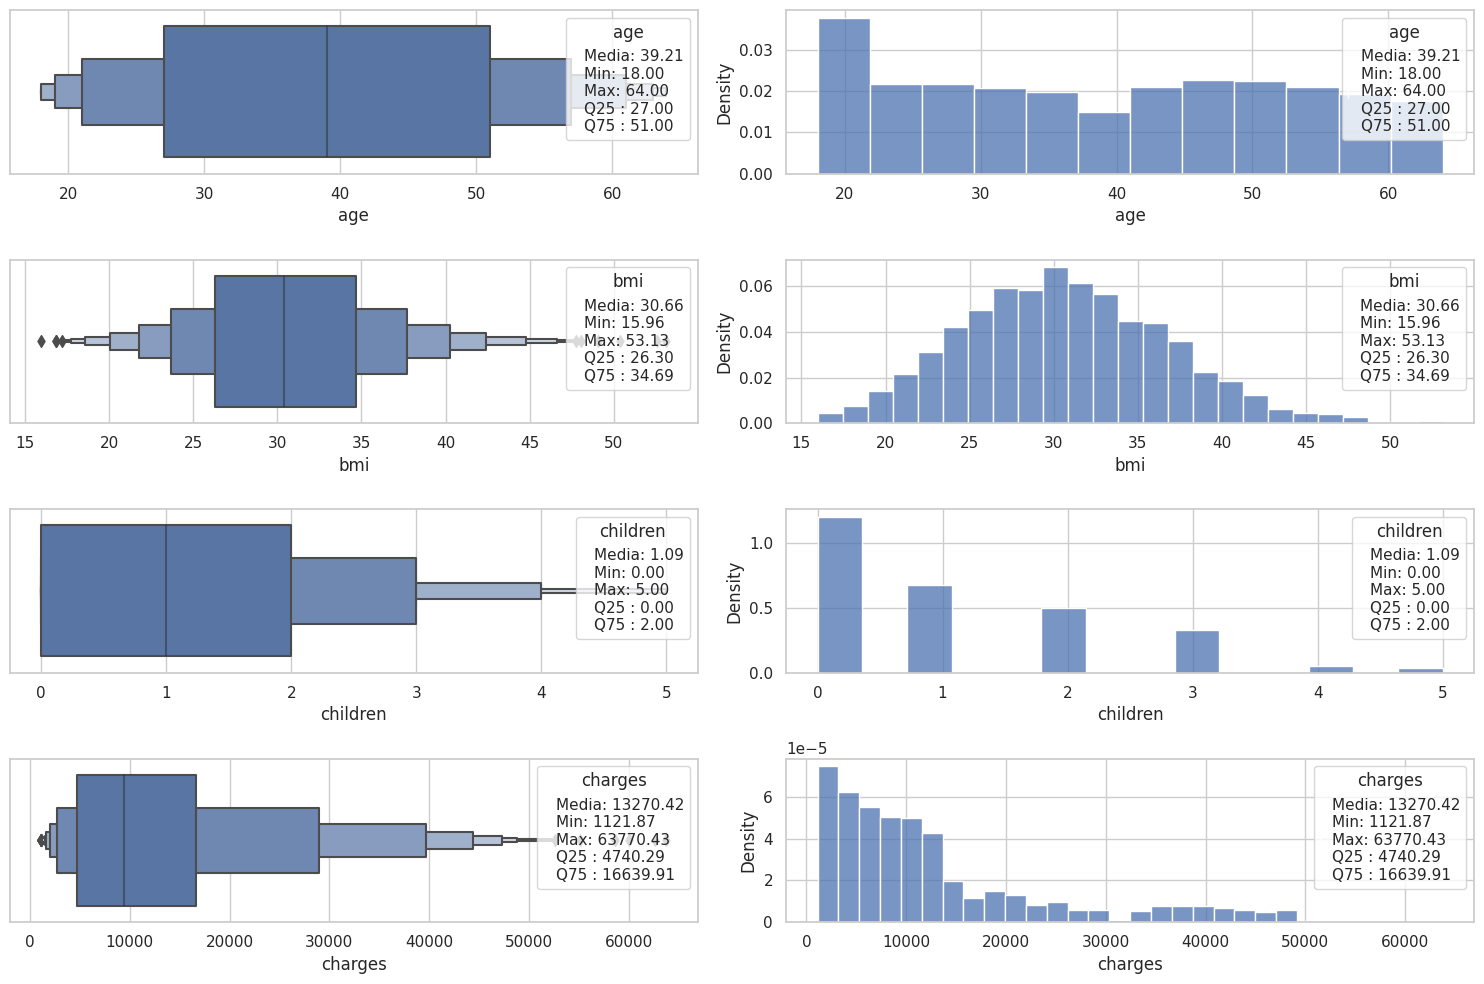

In [10]:
numerical_variables = df_eda.select_dtypes(include = [np.number]).columns

# Hagamos un boxenplot de cada variable, para observar sus rangos y la posible presencia de outliers

for idx, col in enumerate(numerical_variables):
    plt.subplot(4, 2, idx *2 + 1)
    sns.boxenplot(x = df_eda[col])

    # Calcula los valores mínimos, máximos y medios
    min_val = df_eda[col].min()
    max_val = df_eda[col].max()
    mean_val = df_eda[col].mean()
    q25 = df_eda[col].quantile(0.25)
    q75 = df_eda[col].quantile(0.75)
    
    # Agrega la leyenda al gráfico y quita el icono de la leyenda
    plt.legend([f'Media: {mean_val:.2f}\nMin: {min_val:.2f}\nMax: {max_val:.2f}\nQ25 : {q25:.2f}\nQ75 : {q75:.2f}'], loc='upper right', title=col, handlelength=0)


for idx, col in enumerate(numerical_variables):
    plt.subplot(4, 2, idx * 2 + 2)

    # Hagamos que este histograma sea porcentual
    sns.histplot(x = df_eda[col], stat = 'density')

    # Calcula los valores mínimos, máximos y medios
    min_val = df_eda[col].min()
    max_val = df_eda[col].max()
    mean_val = df_eda[col].mean()
    q25 = df_eda[col].quantile(0.25)
    q75 = df_eda[col].quantile(0.75)
    
    # Agrega la leyenda al gráfico y quita el icono de la leyenda
    plt.legend([f'Media: {mean_val:.2f}\nMin: {min_val:.2f}\nMax: {max_val:.2f}\nQ25 : {q25:.2f}\nQ75 : {q75:.2f}'], loc='upper right', title=col, handlelength=0)


plt.tight_layout()  # Ajusta automáticamente los subplots para que se ajusten al área de la figura
plt.show()  # Muestra los gráficos

**Observamos que** 
* Las edades en nuestra muestra varian entre los 18 y 64 años.
* La edad se distribuye aproximadamente de manera uniforme en la muestra, con una ligera concentración en los rangos de 20 a 30 años.
* El Indice de Masa Corporal (BMI) se distribuye aproximadamente de manera normal, sin embargo, la media está por encima de 30, lo cual indica que al menos el 50% de los individuos en la muestra tienen sobrepeso.
* El 75% de los individuos en la muestra tienen como máximo 2 hijos.
* Los cargos por seguros varían ampliamente, con una media significativamente alta en comparación con el Q25, lo que podría indicar que hay un pequeño número de casos con costos extremadamente altos

### Análisis de variables categóricas

In [9]:
categorical_variables = df_eda.select_dtypes(include='object').columns

In [12]:

print('Categorical variables\n')
print(df_eda[categorical_variables].describe())

Categorical variables

         sex smoker     region
count   1338   1338       1338
unique     2      2          4
top     male     no  southeast
freq     676   1064        364


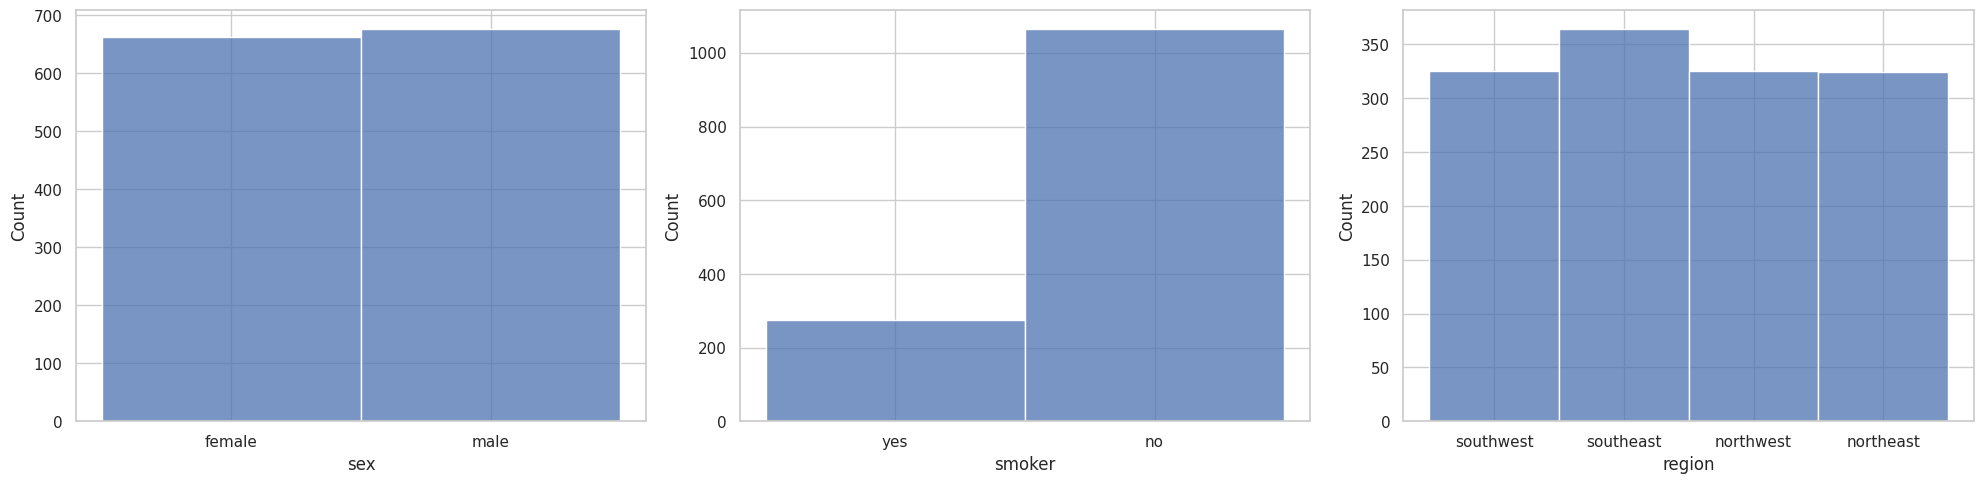

In [13]:
## A continuacion hagamos un countplot para cada una de las varibales categoricas
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for ax, var in zip(axes.flatten(), categorical_variables):
    sns.histplot(x=var, data=df_eda, ax=ax)



plt.tight_layout()

**Observamos que** 
* La muestra está equilibrada en términos de género.
* La mayoría de los individuos en la muestra no son fumadores, por lo cual sería interesante ver la influencia de este factor en los costos.
* La distribución por regiones muestra que hay una distribución relativamente equilibrada entre las cuatro regiones.

### Análisis de la influencia de la variable _smoker_ en los costos.

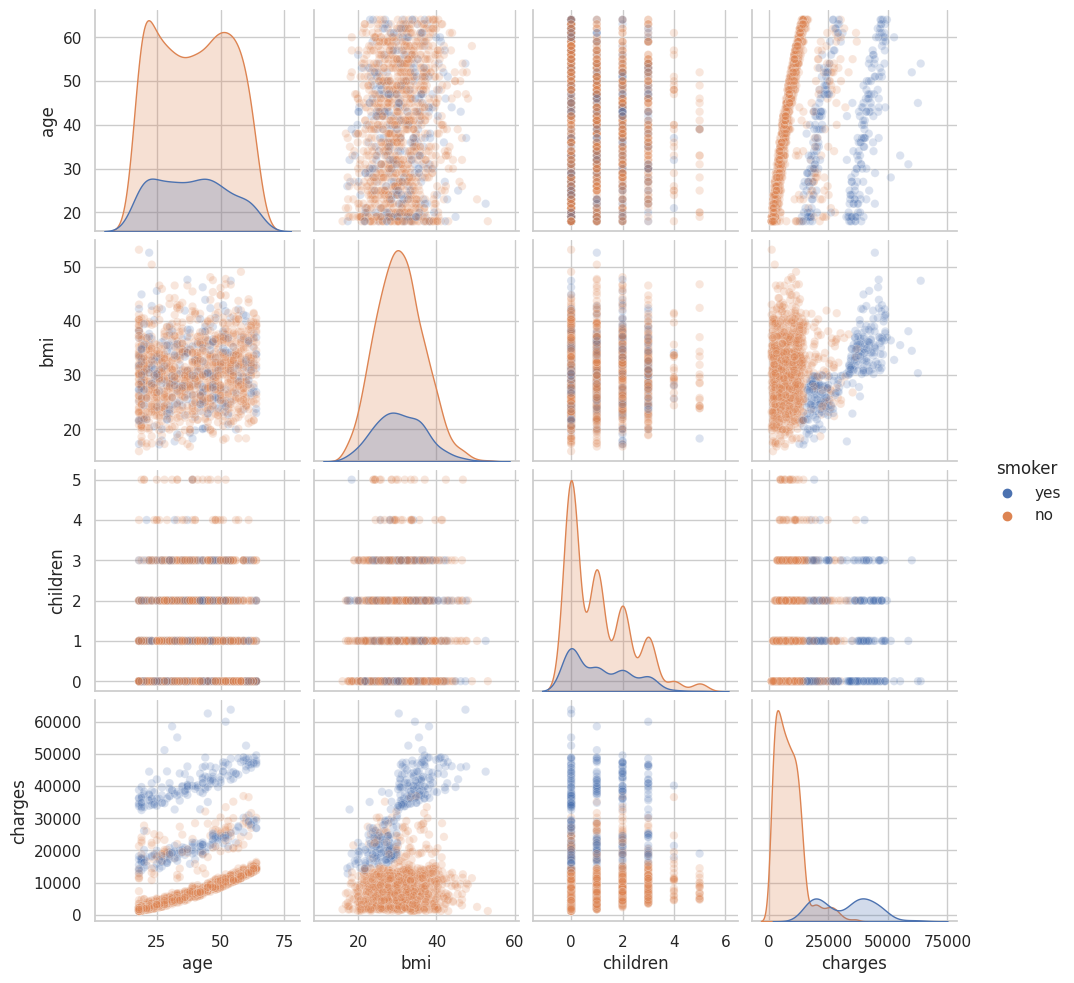

In [14]:
sns.pairplot(df_eda, hue='smoker', plot_kws={'alpha':1/5})

De este diagrama de pares podemos observar que:
* La relación entre edad y costo es positiva, lo que indica que a medida que la edad aumenta, los costos tienden a ser más altos.
* Además, los fumadores tienden a tener costos más altos que los no fumadores, independientemente de la edad.
* El índice de masa corporal (BMI) parece tener una relación positiva con los costos para los fumadores, mientras que para los no fumadores la relación no es tan clara.
* La cantidad de hijos no parece tener una influencia significativa en los costos.

### Análisis de correlaciones
Para poder llevar a cabo este análisis incluyendo las variables categóricas, en primer lugar se deben transformar dichas variables, en este caso, con un codificación OneHot.
En el cual se crea una columna por cada categoría, y asigna un 1 si el individuo pertenece a esa categoría, y un 0 si no.

In [10]:
## Se convierten las categorical variables en OneHotEncoding
for var in categorical_variables:
    df_eda = pd.concat([df_eda, pd.get_dummies(df_eda[var], prefix=var)], axis=1)
    df_eda.drop(var, axis=1, inplace=True)

charges = df_eda.pop('charges')
df_eda['charges'] = charges

In [11]:
df_eda.replace([True, False], [1, 0], inplace=True)
df_eda

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,charges
0,19,27.900,0,1,0,0,1,0,0,0,1,16884.92400
1,18,33.770,1,0,1,1,0,0,0,1,0,1725.55230
2,28,33.000,3,0,1,1,0,0,0,1,0,4449.46200
3,33,22.705,0,0,1,1,0,0,1,0,0,21984.47061
4,32,28.880,0,0,1,1,0,0,1,0,0,3866.85520
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,0,1,1,0,0,1,0,0,10600.54830
1334,18,31.920,0,1,0,1,0,1,0,0,0,2205.98080
1335,18,36.850,0,1,0,1,0,0,0,1,0,1629.83350
1336,21,25.800,0,1,0,1,0,0,0,0,1,2007.94500


<AxesSubplot:>

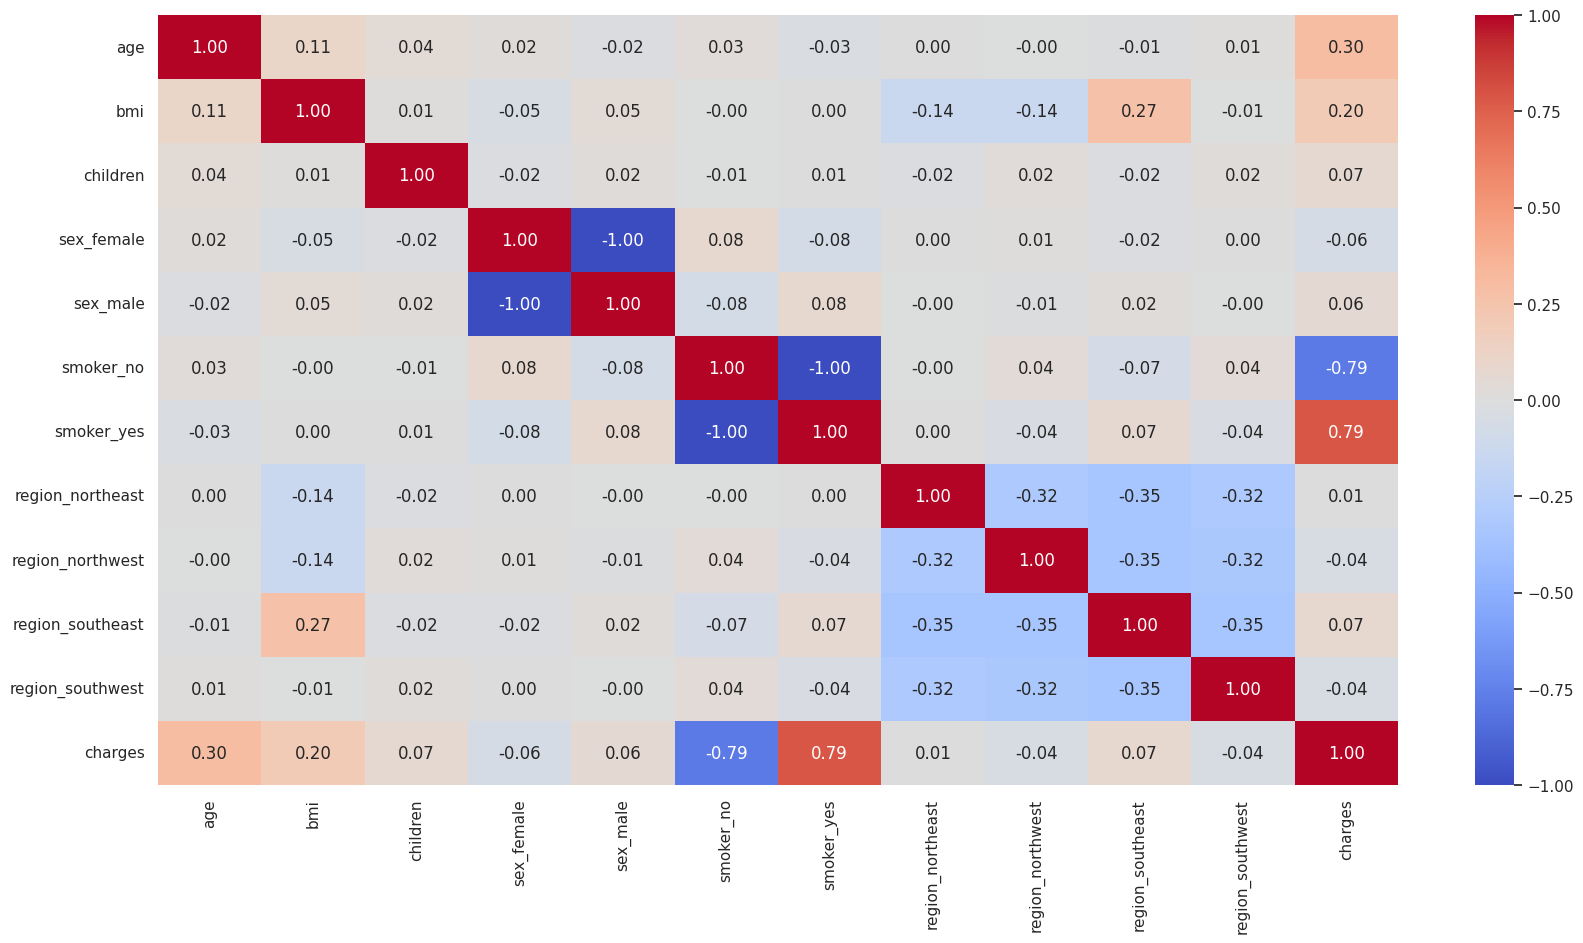

In [25]:
plt.figure(figsize=(20, 10))
# Redondeamos la correlacion a 2 decimales
sns.heatmap(df_eda.corr(), annot=True, cmap='coolwarm', fmt=".2f" )

In [12]:
df_eda.drop(['sex_male','smoker_no'], axis=1, inplace=True)

Notemos que en el dataset transformado, existen variables con una correlación muy alta, algunas incluso con correlación completa,lo que puede resular en un problema para los modelos de Machine Learning, ya que puede haber multicolinealidad. Por lo que se procederá a eliminar las siguientes variables :
- sex_male
- smoker_no

Además se observa que la variable mas correlacionada linealmente con _charges_ es _smoker_yes_, y la segunda mas correlacionada es _age_, lo cual es consistente con el análisis previo.

### Verificación de nulos
Se verifica, por medio de una matriz de nulidad, la ausencia de nulos en el dataset, ya que estos pueden ser un problema para los modelos de Machine Learning.

<AxesSubplot:>

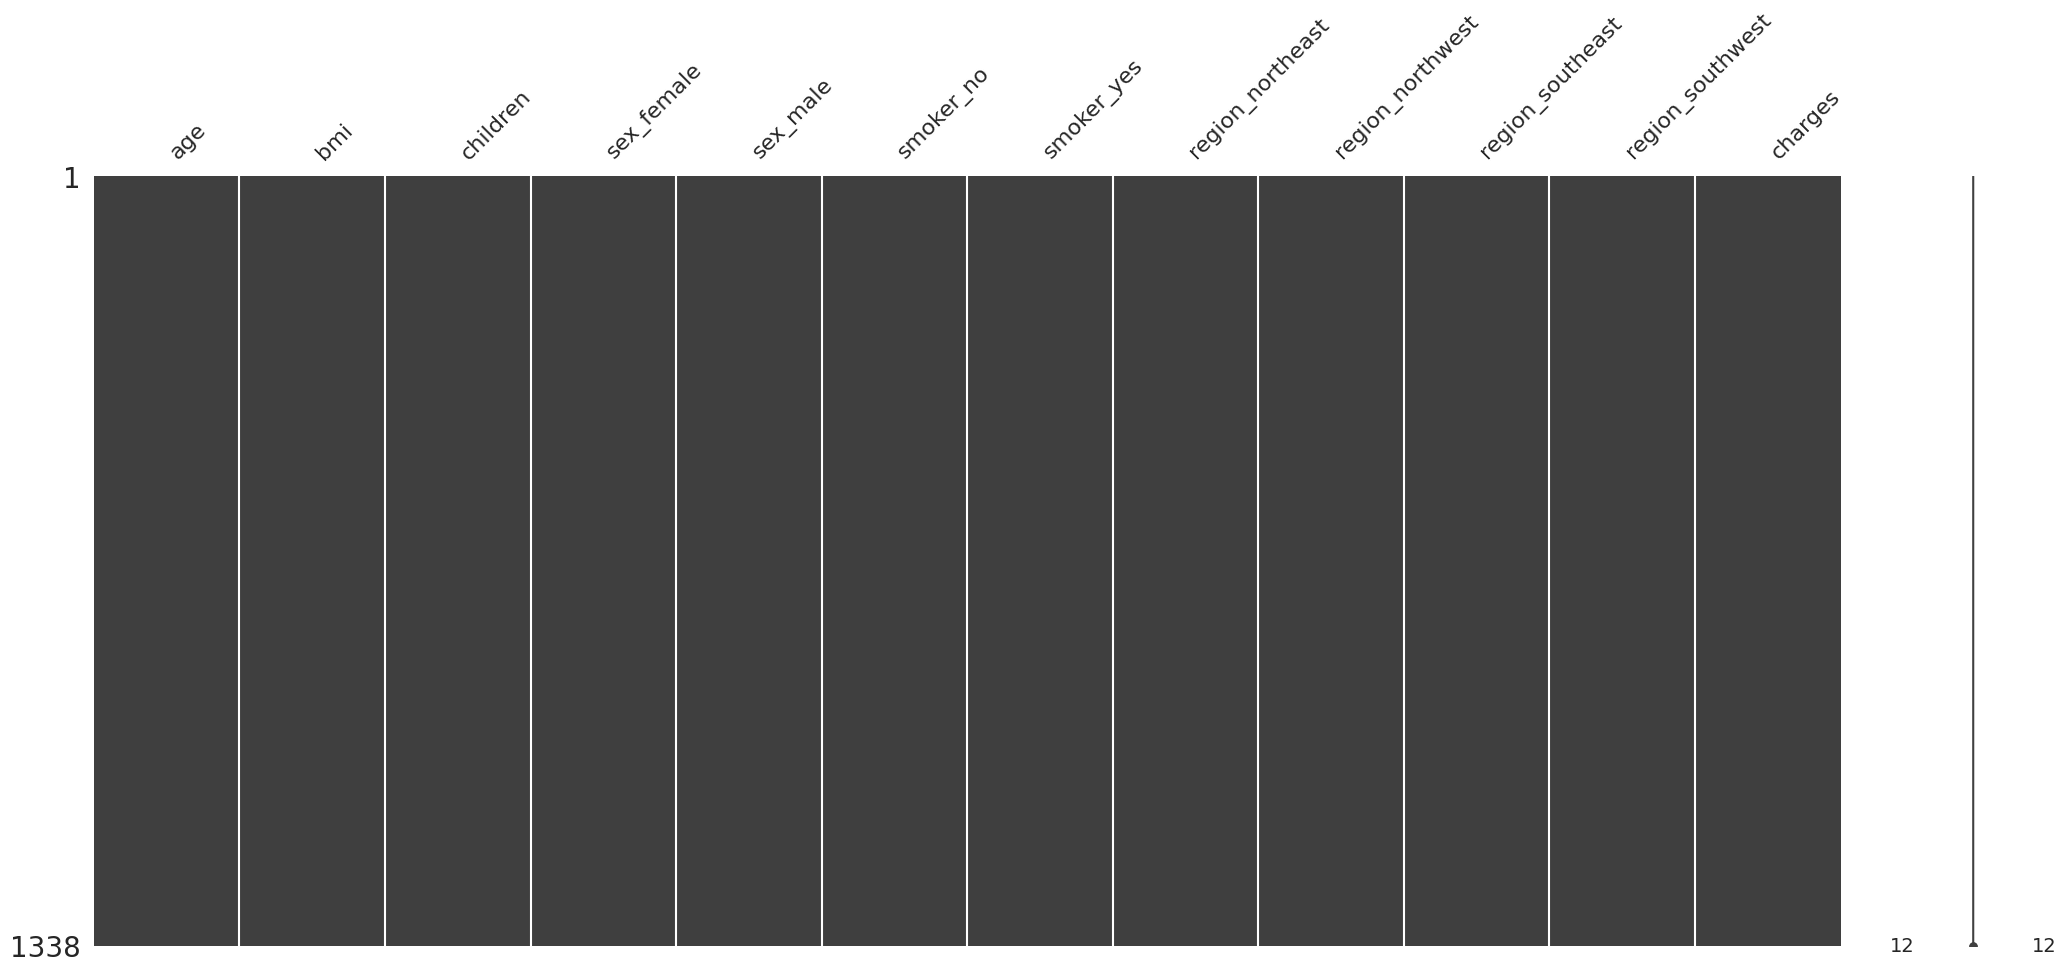

In [26]:
msno.matrix(df_eda)

## Construcción del modelo
Ya habiendo explorado los datos, y comprendido su comportamiento, procederemos a construir un modelo de regresión lineal, el cual nos permitirá predecir los costos médicos individuales facturados por el seguro de salud.

Se escoge este modelo ya que es un modelo simple, y fácil de interpretar, además de que es un buen punto de partida para la construcción de modelos más complejos.

#### Esalamiento de los datos
El escalamiento de datos juega un papel importante en la construcción de modelos predictivos, ya que permite que las variables tengan el mismo peso en el modelo, evitando que una variable con valores más altos tenga un peso mayor en el modelo.

En este caso se utilizará el escalamiento StandardScaler, ya que los algoritmos de regresión lineal asume que los datos siguen una distribución normal. Además, este escalamiento es robusto ante la presencia de outliers, los cuales se presentan, especialmente en la variable _charges_.

In [13]:
df_to_model = df_eda

In [76]:
X, y = df_to_model.drop('charges', axis = 1) , df_to_model.charges

In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # Usando .values y .reshape
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

### Regresión Lineal
A continuación, se construyen los modelos de regresión utilizando el algoritmo de regresión lineal. y posteriormente, se optimizan los parametros buscando mejorar el rendimiento del modelo.


**Métricas de evaluación**
Para evaluar el rendimiento del modelo, se utilizarán las siguientes métricas:
* R2 Score: Mide la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes.   

    (Un valor de R² de 1 indica un ajuste perfecto)
* Mean Squared Error (MSE): Mide el promedio de los errores al cuadrado, es decir, la diferencia entre el valor predicho y el valor real al cuadrado.  

    (Un MSE más bajo indica un mejor ajuste del modelo.)


In [79]:
## Se define la funcion para imprimir los resultados de los modelos
from sklearn.metrics import r2_score, mean_squared_error

def print_model_metrics(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    print(
        f"Resultados del modelo\n"
        f"--------------------------------------\n"
        f"R^2 en el conjunto de entrenamiento: {round(r2_train, 3)}\n"
        f"R^2 en el conjunto de prueba: {round(r2_test, 3)}\n"
        f"--------------------------------------\n"
        f"Mean Squared Error en el conjunto de entrenamiento: {round(mse_train, 3)}\n"
        f"Mean Squared Error en el conjunto de prueba: {round(mse_test, 3)}\n"
    )

#### Modelo 1
Para el primer modelo se realiza el entrenamiento con todos los datos procesados, tanto las observaciones como sus variables independientes.

In [82]:
from sklearn.linear_model import LinearRegression

# Se instancia el modelo
model_1 = LinearRegression()

# Se entrena el modelo
model_1.fit(X_train_scaled, y_train_scaled)

# Se imprimen los resultados
print_model_metrics(model_1, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

Resultados del modelo
--------------------------------------
R^2 en el conjunto de entrenamiento: 0.754
R^2 en el conjunto de prueba: 0.733
--------------------------------------
Mean Squared Error en el conjunto de entrenamiento: 0.246
Mean Squared Error en el conjunto de prueba: 0.25



#### Modelo 2
Para el segundo modelo se entrena con aquellas variables independientes que presentan una correlación mayor a 0.1 con la variable _charges_.

Por ende, en primer lugar se seleccionan las variables que cumplen con dicho criterio, se estandarizan y posteriormente se entrena el modelo.

In [70]:
## Se toman aquellas variables que tienen un coeficiente de correlacion mayor a 0.1 con la variable charges
X, y = df_to_model.drop('charges', axis = 1)[['age', 'bmi', 'smoker_yes']] , df_to_model.charges

# Se crean los estandarizadores
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Se dividen los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

# Se escalan los datos
X_train_scaled_model_2 = scaler_X.fit_transform(X_train)
X_test_scaled_model_2 = scaler_X.transform(X_test)

y_train_scaled_model_2 = scaler_y.fit_transform(y_train.values.reshape(-1, 1)) 
y_test_scaled_model_2 = scaler_y.transform(y_test.values.reshape(-1, 1))


In [81]:
# Se instancia el modelo
model_2 = LinearRegression()

# Se entrena el modelo
model_2.fit(X_train_scaled_model_2, y_train_scaled_model_2)

# Se imprimen los resultados
print_model_metrics(model_2, X_train_scaled_model_2, y_train_scaled_model_2, X_test_scaled_model_2, y_test_scaled_model_2)

Resultados del modelo
--------------------------------------
R^2 en el conjunto de entrenamiento: 0.751
R^2 en el conjunto de prueba: 0.732
--------------------------------------
Mean Squared Error en el conjunto de entrenamiento: 0.249
Mean Squared Error en el conjunto de prueba: 0.251



#### Modelo 3
Para el tercer modelo se entrena con aquellas variables independientes que presentan una correlación mayor a 0.2 con la variable _charges_. y además se realiza un preprocesamiento de los datos, agregando polinomios de segundo grado a las variables independientes. 

Esto se hace con el fin de mejorar el rendimiento del modelo, ya que se pueden capturar relaciones no lineales entre las variables independientes y la variable dependiente.

In [94]:
from sklearn.preprocessing import PolynomialFeatures

# Configuración de las características polinómicas
degree = 2  # Puedes cambiar esto para experimentar con diferentes grados
poly_features = PolynomialFeatures(degree=degree)

# Transformar las características originales a características polinómicas
X_train_poly = poly_features.fit_transform(X_train_scaled_model_2)
X_test_poly = poly_features.transform(X_test_scaled_model_2)

# Crear y ajustar el modelo de regresión lineal
poly_lr_model_3 = LinearRegression()
poly_lr_model_3.fit(X_train_poly, y_train_scaled_model_2)

# Se imprimen los resultados
print_model_metrics(poly_lr_model_3, X_train_poly, y_train_scaled_model_2, X_test_poly, y_test_scaled_model_2)


Resultados del modelo
--------------------------------------
R^2 en el conjunto de entrenamiento: 0.844
R^2 en el conjunto de prueba: 0.814
--------------------------------------
Mean Squared Error en el conjunto de entrenamiento: 0.156
Mean Squared Error en el conjunto de prueba: 0.174



In [128]:
coefficients = poly_lr.coef_  # Coeficientes del modelo

coefficients = np.log(np.abs(coefficients))  # Aplicar logaritmo a los coeficientes para visualización más clara
features = np.array(['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2'])

# cambiar los nombres de las características
features = np.array(['intercept', 'age', 'bmi', 'smoker_yes', 'age^2', 'age x bmi', 'age x smoker_yes', 'bmi^2', 'bmi x smoker_yes', 'smoker_yes^2'])

# Asegurarse de que los coeficientes son un array 1D
coefficients = coefficients.flatten()

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 8))
plt.barh(features, coefficients, color='skyblue')
plt.xlabel('log(abs(coeficiente))')
plt.title('Importancia de las Características')
plt.axvline(x=0, color='grey', linewidth=0.8)
plt.show()

AttributeError: 'PolynomialFeatures' object has no attribute 'get_feature_names'

#### Modelo 4
Para el cuarto, y último modelo, se entrena con todas las variables independientes y además se realiza un preprocesamiento de los datos, agregando polinomios de segundo grado a todas las variables independientes. 

In [93]:
# Configuración de las características polinómicas
degree = 2  # Puedes cambiar esto para experimentar con diferentes grados
poly_features = PolynomialFeatures(degree=degree)

# Transformar las características originales a características polinómicas
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Crear y ajustar el modelo de regresión lineal
poly_lr_model_4 = LinearRegression()
poly_lr_model_4.fit(X_train_poly, y_train_scaled)

# Se imprimen los resultados
print_model_metrics(poly_lr_model_4, X_train_poly, y_train_scaled, X_test_poly, y_test_scaled)


Resultados del modelo
--------------------------------------
R^2 en el conjunto de entrenamiento: 0.855
R^2 en el conjunto de prueba: 0.807
--------------------------------------
Mean Squared Error en el conjunto de entrenamiento: 0.145
Mean Squared Error en el conjunto de prueba: 0.181



(array([[ 0.00000000e+00,  2.99673143e-01,  1.52019556e-01,
         -5.10610690e+10,  3.83624393e-02,  1.42625592e-02,
         -9.02077512e-03, -2.48888467e-02,  2.94083680e-01,
          3.42067817e+10]]),
 array(['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2',
        'x2^2'], dtype=object))

## Conclusiones